In [1]:
import pandas as pd

fp = '../2D.csv'
df = pd.read_csv(fp)
p1 = 'P1'
p2 = 'P2'
p3 = 'P3'
p4 = 'P4'
p5 = 'P5'
target = 'Cost'
df

,P1,P2,P3,P4,P5,Cost
0,-50,102,-49,90,-94,12292.0
1,-48,101,-48,94,-97,12294.0
2,-48,101,-48,94,-96,12294.0
3,-42,97,-42,95,-94,12296.0
4,-42,100,-41,92,-94,12296.0
...,...,...,...,...,...,...
18124,49,-62,38,-47,77,44360.0
18125,54,-97,92,-67,-15,44434.0
18126,37,-83,50,-98,62,44602.0
18127,85,-94,48,-87,37,44644.0


In [2]:
df.describe()

,P1,P2,P3,P4,P5,Cost
count,18129.000000,18129.000000,18129.000000,18129.000000,18129.000000,18129.000000
mean,-36.567378,54.386618,-42.064593,53.517679,-56.640631,14817.796900
std,37.391820,53.033530,33.198714,37.395383,48.694947,6913.312738
min,-104.000000,-100.000000,-105.000000,-100.000000,-114.000000,12292.000000
25%,-58.000000,26.000000,-61.000000,44.000000,-94.000000,12338.000000
50%,-45.000000,82.000000,-44.000000,63.000000,-75.000000,12532.000000
75%,-30.000000,95.000000,-34.000000,77.000000,-38.000000,13214.000000
max,102.000000,109.000000,100.000000,103.000000,102.000000,54556.000000


In [3]:
df.keys()

Index(['P1', 'P2', 'P3', 'P4', 'P5', 'Cost'], dtype='object')

<Axes: xlabel='P3', ylabel='P4'>

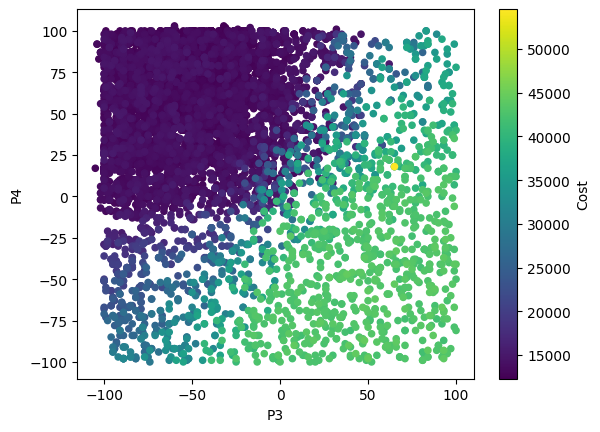

In [9]:
df.plot(x=p3, y=p4, kind='scatter', c=target)

array([[<Axes: title={'center': 'Cost'}>]], dtype=object)

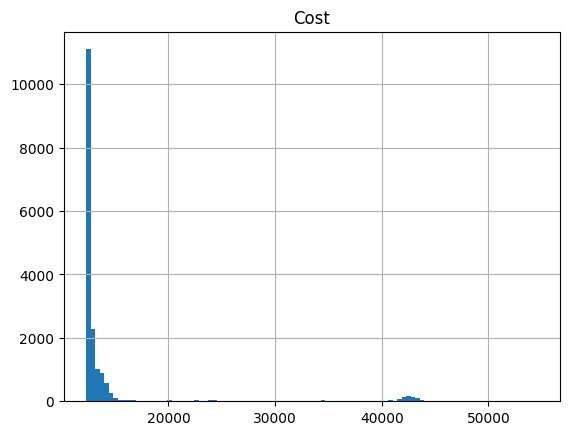

In [10]:
df.hist(column=target,bins=100)

In [12]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(random_state=123, hidden_layer_sizes=[30,30], solver='lbfgs', alpha=0.0001)